In [152]:
import pandas as pd
import numpy as np
import math

In [153]:
#MeanImputer
class MeanImputer():
    def __init__(self, copy=True):
        self.copy = copy
    def __is_numpy(self, X):
        #X : pandas.DataFrame или numpy.ndarray
        #Is it numpy or not
        return isinstance(X, np.ndarray)
    def fit(self, X, y=None):
        self._encoder_dict = {}
        is_np = self.__is_numpy(X)
        #reshape from 1D to 2D
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        #amount of columns
        ncols = X.shape[1]
        
        if is_np:
            for col in range(ncols):
                self._encoder_dict[col] = np.nanmean(X[:, col])
        else:
            for col in X.columns:
                self._encoder_dict[col] = X[col].mean()
                
        return self
    
    def transform(self, X):
        if self.copy:
            X = X.copy()
        is_np = self.__is_numpy(X)
        
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        ncols = X.shape[1]
        
        if is_np:
            for col in range(ncols):
                X[:, col] = np.nan_to_num(
                    X[:, col],
                nan=self._encoder_dict[col])
        else:
            for col in X.columns:
                X[col] = np.where(X[col].isnull(),
                                    self._encoder_dict[col],
                                    X[col])
        return X    

In [154]:
toy_train = pd.DataFrame(
{'Balance': [8.3, np.NaN, 10.2, 3.1],
'Age': [23, 29, 36, np.NaN]})
toy_train

,Balance,Age
0,8.3,23.0
1,NaN,29.0
2,10.2,36.0
3,3.1,NaN


In [155]:
toy_test = pd.DataFrame(
{'Balance': [10.4, np.NaN, 22.5, 1.1],
'Age': [13, 19, 66, np.NaN]})
toy_test

,Balance,Age
0,10.4,13.0
1,NaN,19.0
2,22.5,66.0
3,1.1,NaN


In [156]:
#Using mean()
'''
for col in toy_train.columns:
    toy_train[col].fillna(toy_train[col].mean(), inplace=True)
    toy_test[col].fillna(toy_train[col].mean(), inplace=True)
print('обучающий датафрейм')
print(toy_train)
print('')
print('тестовый датафрейм')
print(toy_test)
'''

"\nfor col in toy_train.columns:\n    toy_train[col].fillna(toy_train[col].mean(), inplace=True)\n    toy_test[col].fillna(toy_train[col].mean(), inplace=True)\nprint('обучающий датафрейм')\nprint(toy_train)\nprint('')\nprint('тестовый датафрейм')\nprint(toy_test)\n"

In [157]:
imp = MeanImputer()
imp.fit(toy_train)
toy_train = imp.transform(toy_train)
toy_train

,Balance,Age
0,8.3,23.000000
1,7.2,29.000000
2,10.2,36.000000
3,3.1,29.333333


In [158]:
toy_test = imp.transform(toy_test)
toy_test

,Balance,Age
0,10.4,13.000000
1,7.2,19.000000
2,22.5,66.000000
3,1.1,29.333333


In [159]:
toy_train = pd.DataFrame(
{'Balance': [8.3, np.NaN, 10.2, 3.1],
'Age': [23, 29, 36, np.NaN]})
# создаем экземпляр класса, отключив копирование
imp = MeanImputer(copy=False)
# обучаем модель
imp.fit(toy_train[['Age']])
# применяем модель
toy_train['Age'] = imp.transform(toy_train[['Age']])
toy_train

C:\Users\Андрей Куликов\AppData\Local\Temp\ipykernel_15192\1614832478.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.where(X[col].isnull(),


,Balance,Age
0,8.3,23.000000
1,NaN,29.000000
2,10.2,36.000000
3,3.1,29.333333


In [160]:
np_toy_train = np.array(pd.DataFrame(
{'Balance': [8.3, np.NaN, 10.2, 3.1],
'Age': [23, 29, 36, np.NaN]}))
np_toy_train

np_toy_test = np.array(pd.DataFrame(
{'Balance': [10.4, np.NaN, 22.5, 1.1],
'Age': [13, 19, 66, np.NaN]}))
np_toy_test

array([[10.4, 13. ],
       [ nan, 19. ],
       [22.5, 66. ],
       [ 1.1,  nan]])

In [161]:
imp.fit(np_toy_train)
np_toy_train = imp.transform(np_toy_train)
np_toy_train

array([[ 8.3       , 23.        ],
       [ 7.2       , 29.        ],
       [10.2       , 36.        ],
       [ 3.1       , 29.33333333]])

In [162]:
np_toy_test = imp.transform(np_toy_test)
np_toy_test

array([[10.4       , 13.        ],
       [ 7.2       , 19.        ],
       [22.5       , 66.        ],
       [ 1.1       , 29.33333333]])

In [163]:
#KNN Model code;

class KNN_Estimator():
    def _euclidean_distance(self, x1, x2):
        distance = 0
        for i in range(len(x1)):
            distance += pow((x1[i] - x2[i]), 2)
        return math.sqrt(distance)
    
    def _vote(self, neighbor_labels):
        counts = np.bincount(neighbor_labels.astype('int'))
        return counts.argmax()
    
    def __init__(self, k=5, task='classification'):
        self.k = k
        self.task = task
        self.k_nearest_neighbors_ = []
        
    def fit(self, X, y):
        self.X_memorized = X
        self.y_memorized = y
        
    def predict(self, X):
        y_pred = np.empty(X.shape[0])
        if self.task == 'classification':
            for i, test_sample in enumerate(X):
                idx = np.argsort([self._euclidean_distance(
                    test_sample, x) for x in self.X_memorized])[:self.k]
                k_nearest_neighbors = np.array(
                    [self.y_memorized[i] for i in idx])
                self.k_nearest_neighbors_.append(k_nearest_neighbors)
                y_pred[i] = self._vote(self.k_nearest_neighbors_[i])
        if self.task == 'regression':
            for i, test_sample in enumerate(X):
                idx = np.argsort([self._euclidean_distance(
                    test_sample, x) for x in self.X_memorized])[:self.k]
                k_nearest_neighbors = np.array(
                    [self.y_memorized[i] for i in idx])
                self.k_nearest_neighbors_.append(k_nearest_neighbors)
                y_pred[i] = np.mean(self.k_nearest_neighbors_[i])
        return y_pred    
    

In [164]:
#Classification
X_trn = np.array([[0.1, 0.2, 0.3],
                                [0.7, 0.5, 0.2],
                                [0.1, 0.2, 0.2],
                                [0.9, 0.7, 3.5],
                                [0.2, 0.4, 1.4],
                                [0.4, 0.1, 0.5]])

y_trn = np.array([1, 0, 1, 0, 0, 1])

X_tst = np.array([[0.1, 0.7, 1.1],
                                [0.5, 0.3, 2.8],
                                [0.1, 0.1, 0.2],
                                [0.9, 0.7, 1.5]])

In [165]:
knn = KNN_Estimator(k=3, task='classification')
knn.fit(X_trn, y_trn)

pred = knn.predict(X_tst)
pred

array([1., 0., 1., 0.])

In [166]:
knn.k_nearest_neighbors_

[array([0, 1, 1]), array([0, 0, 1]), array([1, 1, 1]), array([0, 1, 0])]

In [167]:
y_trn = np.array([1.2, 0.5, 1.4, 2.2, 3.5, 5.9])

In [168]:
knn = KNN_Estimator(k=3, task='regression')
knn.fit(X_trn, y_trn)

In [169]:
pred = knn.predict(X_tst)
pred

array([3.53333333, 3.86666667, 2.83333333, 3.3       ])

In [170]:
knn.k_nearest_neighbors_

[array([3.5, 5.9, 1.2]),
 array([2.2, 3.5, 5.9]),
 array([1.4, 1.2, 5.9]),
 array([3.5, 5.9, 0.5])]

In [171]:
a = [2, 4, 7, 9, 14, 20, 21, 22]
b = [3, 5, 8, 10, 14, 20, 21, 30]

def seven(a,b):
    for i in range(len(a)):
            if a[i] % 7 == 0 and b[i] % 7 == 0:
                print(a[i])
            else:
                pass

In [172]:
seven(a,b)

14
21


In [173]:
def find(lst1, lst2):
    lst1 = [i for i in lst1 if i % 7 == 0]
    lst2 = [i for i in lst2 if i % 7 == 0]
    return set(lst1) & set(lst2)

find(a,b)

{14, 21}

In [174]:
a = ["a", "b", "c", "d", "e", "f"]
b = [1, 0, 9, 3, 2, 0]

In [175]:
def get_sorted(lst1, lst2):
    lst_tmp = [x for x in zip(lst1, lst2)]
    lst_tmp.sort(key=lambda x: x[1])
    return [x[0] for x in lst_tmp]

In [176]:
get_sorted(a,b)

['b', 'f', 'a', 'e', 'd', 'c']

In [177]:
z = zip(a,b)
z = list(z)
z

[('a', 1), ('b', 0), ('c', 9), ('d', 3), ('e', 2), ('f', 0)]

In [178]:
#Pipeline

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [179]:
os.getcwd()

'f:\\KULIKOV\\ML\\MLCourseAI\\Data Analytics 2023 V2\\ML DA may 2023'

In [180]:
#Loaddataset
from sklearn.datasets import fetch_covtype
import pandas as pd
#https://scikit-learn.ru/7-2-real-world-datasets/
#https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_outlier_detection_bench.html#sphx-glr-auto-examples-miscellaneous-plot-outlier-detection-bench-py

X, y = fetch_covtype(return_X_y=True, as_frame=True)
s = (y == 2) + (y == 4)
X = X.loc[s]
y = y.loc[s]
y = (y != 2).astype(np.int32)

#X, _, y, _ = train_test_split(X, y, train_size=0.05, stratify=y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [181]:
#Scaling
standardscaler = StandardScaler()
standardscaler.fit(X_train)
# Transform ONLY to train and test, not to X. Because in X - other meanings.
X_train_standardscaled = standardscaler.transform(X_train)  
X_test_standardscaled = standardscaler.transform(X_test)

In [182]:
#TFitting
logreg = LogisticRegression(solver='lbfgs', max_iter=400)
logreg.fit(X_train_standardscaled, y_train)
print("Score train: {:.3f}".format(
logreg.score(X_train_standardscaled, y_train)))
print("Score test: {:.3f}".format(
logreg.score(X_train_standardscaled, y_train)))

Score train: 1.000
Score test: 1.000


In [183]:
#Getting score
train_score = logreg.score(X_train_standardscaled, y_train)
test_score = logreg.score(X_test_standardscaled, y_test)
print(f"Score train: {train_score:.3f}")
print(f"Score test: {test_score:.3f}")

Score train: 1.000
Score test: 1.000


In [184]:
print("Score train: %.3f" % train_score)
print("Score test: %.3f" % test_score)

Score train: 1.000
Score test: 1.000


In [185]:
#Predictiong
logreg_pred = logreg.predict(X_test_standardscaled)
logreg_pred

array([0, 0, 0, ..., 0, 0, 0])

In [186]:
#Predicting probability
logreg_pred = logreg.predict_proba(X_test_standardscaled)
logreg_pred

array([[9.99999997e-01, 3.43359067e-09],
       [9.99999998e-01, 2.17678902e-09],
       [1.00000000e+00, 1.21786506e-12],
       ...,
       [1.00000000e+00, 2.28650412e-10],
       [1.00000000e+00, 3.19741413e-12],
       [1.00000000e+00, 6.61051203e-19]])

In [187]:
#Constant
intercept = np.round(logreg.intercept_, 3)
intercept

array([-25.609])

In [188]:
#Coef
coef = np.round(logreg.coef_, 3)
coef

array([[-6.863e+00, -4.450e-01,  4.950e-01, -4.370e-01, -3.320e-01,
         4.905e+00,  9.090e-01,  1.671e+00, -1.179e+00,  1.724e+00,
        -2.480e-01,  1.000e-03, -2.350e-01,  1.721e+00,  2.110e-01,
        -4.000e-03,  5.290e-01,  1.100e-02,  1.590e-01,  1.800e-01,
        -1.000e-03, -1.000e-03, -1.000e-03, -1.590e-01,  5.040e-01,
        -1.900e-02, -1.000e-03,  1.890e-01,  0.000e+00, -6.400e-02,
         2.500e-02, -5.600e-02, -0.000e+00, -3.900e-02,  0.000e+00,
         1.000e-03, -0.000e+00, -1.100e-02,  0.000e+00, -4.000e-03,
         1.000e-03,  0.000e+00, -8.100e-02, -2.860e-01,  1.000e-03,
         2.000e-03,  1.000e-03,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  1.000e-03,  0.000e+00,  0.000e+00]])

In [189]:
#Classes
classes = np.round(logreg.classes_, 3)
classes

array([0, 1])

In [190]:
logreg.coef_[0]

array([-6.86335327e+00, -4.44872949e-01,  4.95230289e-01, -4.37066814e-01,
       -3.32491131e-01,  4.90456158e+00,  9.09293036e-01,  1.67094079e+00,
       -1.17893584e+00,  1.72418089e+00, -2.47727420e-01,  1.30181700e-03,
       -2.34978485e-01,  1.72075737e+00,  2.11016259e-01, -3.53628838e-03,
        5.28561367e-01,  1.07845255e-02,  1.59423234e-01,  1.79662757e-01,
       -9.17802709e-04, -1.34119874e-03, -7.05269441e-04, -1.59042417e-01,
        5.03849394e-01, -1.86944028e-02, -9.44020346e-04,  1.89178845e-01,
        0.00000000e+00, -6.44847844e-02,  2.51200087e-02, -5.58369297e-02,
       -2.29150022e-04, -3.91221385e-02,  6.21205535e-05,  8.62002215e-04,
       -2.76901069e-04, -1.08280955e-02,  2.09934128e-04, -4.11126506e-03,
        6.19675404e-04,  2.48454983e-04, -8.14092955e-02, -2.86473120e-01,
        5.78602864e-04,  1.72477402e-03,  5.40896563e-04,  3.61707208e-04,
        8.77095533e-05,  1.56332368e-04,  0.00000000e+00,  6.12474037e-04,
        4.17828904e-04,  

In [191]:
#Coef for features
for i,feature in zip(logreg.coef_[0], X_train.columns):
    print(feature, i)

Elevation -6.863353273500244
Aspect -0.44487294882555245
Slope 0.4952302886105166
Horizontal_Distance_To_Hydrology -0.4370668139499791
Vertical_Distance_To_Hydrology -0.3324911313472247
Horizontal_Distance_To_Roadways 4.904561581176035
Hillshade_9am 0.9092930360668068
Hillshade_Noon 1.6709407882924503
Hillshade_3pm -1.1789358445753517
Horizontal_Distance_To_Fire_Points 1.7241808871037037
Wilderness_Area_0 -0.2477274195599548
Wilderness_Area_1 0.0013018169964458474
Wilderness_Area_2 -0.23497848521813966
Wilderness_Area_3 1.7207573721353782
Soil_Type_0 0.2110162589754352
Soil_Type_1 -0.003536288377687285
Soil_Type_2 0.5285613673827958
Soil_Type_3 0.010784525517597626
Soil_Type_4 0.1594232336686379
Soil_Type_5 0.1796627570199406
Soil_Type_6 -0.0009178027089207292
Soil_Type_7 -0.0013411987397579893
Soil_Type_8 -0.0007052694408819774
Soil_Type_9 -0.1590424166118983
Soil_Type_10 0.5038493940734217
Soil_Type_11 -0.018694402803804383
Soil_Type_12 -0.000944020346388549
Soil_Type_13 0.1891788445

In [192]:
#Bootstrap and out-of-bag
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor

In [193]:
X

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2579.0,132.0,6.0,300.0,-15.0,67.0,230.0,237.0,140.0,6031.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,2886.0,151.0,11.0,371.0,26.0,5253.0,234.0,240.0,136.0,4051.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,2742.0,134.0,22.0,150.0,69.0,3215.0,248.0,224.0,92.0,6091.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576882,2617.0,29.0,13.0,390.0,128.0,2081.0,215.0,211.0,130.0,592.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576883,2614.0,21.0,13.0,379.0,125.0,2051.0,211.0,212.0,135.0,618.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576884,2612.0,17.0,13.0,371.0,123.0,2021.0,208.0,211.0,138.0,644.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576885,2610.0,16.0,14.0,365.0,110.0,1991.0,208.0,211.0,138.0,671.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
#Toy regression

var_lst = ['Aspect', 'Slope',
'Horizontal_Distance_To_Hydrology', 'Elevation']
toy_data = X[var_lst].head(10)
toy_labels = toy_data.pop('Elevation')

In [195]:
toy_data.shape

(10, 3)

In [196]:
#Bootstrap - values can be repeated
sample_indices = np.arange(toy_data.shape[0])
rng = np.random.RandomState(42)
bootstrap_indices = rng.choice(sample_indices,
                               size=sample_indices.shape[0],
                               replace=True)
display(bootstrap_indices.shape)
toy_data_boot = toy_data.iloc[bootstrap_indices]
toy_labels_boot = toy_labels.iloc[bootstrap_indices]
display(toy_data_boot)
display(toy_labels_boot)

(10,)

,Aspect,Slope,Horizontal_Distance_To_Hydrology
27,148.0,16.0,323.0
11,151.0,11.0,371.0
28,135.0,1.0,212.0
12,134.0,22.0,150.0
27,148.0,16.0,323.0
41,346.0,2.0,0.0
5,132.0,6.0,300.0
27,148.0,16.0,323.0
28,135.0,1.0,212.0
12,134.0,22.0,150.0


27    2962.0
11    2886.0
28    2811.0
12    2742.0
27    2962.0
41    2570.0
5     2579.0
27    2962.0
28    2811.0
12    2742.0
Name: Elevation, dtype: float64

In [197]:
toy_labels_boot.nunique()

6

In [198]:
#Out-of-bag:
toy_data_out_boot = toy_data[~toy_data.index.isin(
toy_data_boot.index)]
toy_labels_out_boot = toy_labels[~toy_labels.index.isin(
toy_data_boot.index)]
display(toy_data_out_boot)
display(toy_labels_out_boot)

,Aspect,Slope,Horizontal_Distance_To_Hydrology
2,139.0,9.0,268.0
3,155.0,18.0,242.0
21,209.0,17.0,216.0
35,45.0,19.0,242.0


2     2804.0
3     2785.0
21    2880.0
35    2900.0
Name: Elevation, dtype: float64

In [199]:
#bootstrap and out-of-bag function
def generate_bootstrap(rng, X, y, verbose=True):
        sample_indices = np.arange(X.shape[0])
        bootstrap_indices = rng.choice(sample_indices,
                                       size=sample_indices.shape[0],
                                       replace=True)
        X_boot = X.iloc[bootstrap_indices]
        y_boot = y.iloc[bootstrap_indices]
        X_out_boot = X[~X.index.isin(X_boot.index)]
        y_out_boot = y[~y.index.isin(X_boot.index)]
        if verbose:
            print(f"{i}-iteration")
            print(f"indexes in bootstrap: {X_boot.index.tolist()}")
            print(f"indexes in out-of-bag: {X_out_boot.index.tolist()}\n")
        return X_boot, y_boot, X_out_boot, y_out_boot

In [200]:
rng = np.random.RandomState(42)
standardscaler = StandardScaler()
tree = DecisionTreeRegressor(random_state=42)
test_score_lst = []
for i in range(1, 4):
    X_boot, y_boot, X_out_boot, y_out_boot = generate_bootstrap(
    rng, toy_data, toy_labels)
    tree.fit(X_boot, y_boot)
    test_score = tree.score(X_out_boot, y_out_boot)
    test_score_lst.append(test_score)

1-iteration
indexes in bootstrap: [27, 11, 28, 12, 27, 41, 5, 27, 28, 12]
indexes in out-of-bag: [2, 3, 21, 35]

2-iteration
indexes in bootstrap: [11, 28, 28, 5, 21, 12, 3, 28, 21, 3]
indexes in out-of-bag: [2, 27, 35, 41]

3-iteration
indexes in bootstrap: [12, 2, 41, 21, 35, 2, 41, 5, 27, 11]
indexes in out-of-bag: [3, 28]



In [201]:
print(test_score_lst)

[-9.155198273820488, -0.9437390247197082, -184.94378698224853]


In [202]:
mean_r2 = sum(test_score_lst) / len(test_score_lst)
print("Mean Value R2: %.3f" % mean_r2)

Mean Value R2: -65.014


In [203]:
#R2 in list
import statistics
mean_r2 = statistics.fmean(test_score_lst)
print("Mean Value R2: %.3f" % mean_r2)

Mean Value R2: -65.014


In [204]:

rng = np.random.RandomState(42)

standardscaler = StandardScaler()

logreg = LogisticRegression(solver='lbfgs', max_iter=200)

test_score_lst = []

for i in range(15):
    X_boot, y_boot, X_out_boot, y_out_boot = generate_bootstrap(
        rng, X_train, y_train, verbose=False)
    standardscaler.fit(X_boot)
    X_boot_scaled = standardscaler.transform(X_boot)
    X_out_boot_scaled = standardscaler.transform(X_out_boot)
    logreg.fit(X_boot_scaled, y_boot)
   #     X_out_boot_scaled)
    test_score = logreg.score(
        X_out_boot_scaled, y_out_boot)
    test_score_lst.append(test_score)
    

c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

In [205]:
mean_acc = statistics.fmean(test_score_lst)
print("Mean_acc: %.3f" % mean_acc)

Mean_acc: 1.000


In [206]:
test_score_lst

[0.9994562188175479,
 0.9995115730062681,
 0.999687784218171,
 0.9996344880802501,
 0.9995365068978679,
 0.9996464797541674,
 0.9995660134264596,
 0.9994980124004504,
 0.9996871982483102,
 0.9994707127734651,
 0.9996194049123952,
 0.9995658250003392,
 0.9996463932107497,
 0.9996208684819845,
 0.9994968998150767]

In [207]:
#bias_variance

from mlxtend.data import boston_housing_data
boston_housing_data()
X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=123)

#generating bootstrap samples based on a training sample
def _draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(sample_indices,
                                    size=sample_indices.shape[0],
                                    replace=True)
    return X[bootstrap_indices], y[bootstrap_indices]

In [208]:
#function that calculates the average expected value of the function of losses, averaged bias, averaged variance

def bias_variance_decomp(estimator, X_train, y_train, X_test, y_test,
                        num_rounds=200, random_seed=None):
#Author: Sebastian Raschka https://github.com/rasbt

        rng = np.random.RandomState(random_seed)
        all_pred = np.zeros((num_rounds, y_test.shape[0]), dtype=int)

        for i in range(num_rounds):
            X_boot, y_boot = _draw_bootstrap_sample(rng, X_train, y_train)
            pred = estimator.fit(X_boot, y_boot).predict(X_test)
            all_pred[i] = pred
            

        avg_expected_loss = np.apply_along_axis(
            lambda x:
            ((x - y_test) ** 2).mean(),
            axis=1,
            arr=all_pred).mean()

        main_predictions = np.mean(all_pred, axis=0)
        avg_bias = np.sum((main_predictions - y_test) ** 2) / y_test.size
        avg_var = np.sum((main_predictions - all_pred) ** 2) / all_pred.size
        return avg_expected_loss, avg_bias, avg_var

In [209]:
#max depth tree
tree = DecisionTreeRegressor(random_state=123)
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    tree, X_train, y_train, X_test, y_test,
    random_seed=123)

ttl = "avg_expected_loss: %.3f"
print(ttl % avg_expected_loss)
print("avg_bias: %.3f" % avg_bias)
print("avg_var: %.3f" % avg_var)

avg_expected_loss: 31.756
avg_bias: 13.856
avg_var: 17.900


In [210]:
#depth=1 tree
tree2 = DecisionTreeRegressor(random_state=123, max_depth=1)
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    tree2, X_train, y_train, X_test, y_test,
    random_seed=123)

print(ttl % avg_expected_loss)
print("avg_bias: %.3f" % avg_bias)
print("avg_var: %.3f" % avg_var)

avg_expected_loss: 53.199
avg_bias: 41.990
avg_var: 11.209


In [211]:
#what is bias_variance_decomp
X_train = np.array([[29.1, 19000.28, 15],
                    [67.3, 48800.81, 45],
                    [77.9, 89800.55, 188]])
X_test = np.array([[11.9, 89900.28, 199],
                    [37.8, 10600.82, 95],
                    [77.2, 99700.22, 87]])
y_train = np.array([22.6, 89.5, 17.3])
y_test = np.array([12.4, 96.9, 107.9])

rng = np.random.RandomState(123)

all_pred = np.zeros((3, y_test.shape[0]), dtype=int)
all_pred

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [212]:
for i in range(3):
    X_boot, y_boot = _draw_bootstrap_sample(rng, X_train, y_train)
    pred = tree.fit(X_boot, y_boot).predict(X_test)
    all_pred[i] = pred
    
display(all_pred)
y_test

array([[17, 89, 89],
       [17, 22, 22],
       [17, 89, 89]])

array([ 12.4,  96.9, 107.9])

In [213]:
mse_first_iter = (((17 - 12.4)**2) + ((89 - 96.9)**2) +
                 ((89 - 107.9)**2)) / 3
mse_first_iter

146.92666666666676

In [214]:
mse = np.apply_along_axis(
    lambda x:
    ((x - y_test)**2).mean(),
    axis=1,
    arr=all_pred)
mse

array([ 146.92666667, 4336.66      ,  146.92666667])

In [215]:
avg_expected_loss = np.apply_along_axis(
    lambda x:
    ((x - y_test)**2).mean(),
    axis=1,
    arr=all_pred).mean()
avg_expected_loss

1543.504444444445

In [216]:
main_predictions = np.mean(all_pred, axis=0)
main_predictions

array([17.        , 66.66666667, 66.66666667])

In [217]:
avg_bias = np.sum((main_predictions - y_test)**2) / y_test.size
avg_bias

878.4674074074074

In [218]:
avg_var = np.sum((main_predictions - all_pred)**2) / all_pred.size
avg_var

665.037037037037

In [219]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    tree, X_train, y_train, X_test, y_test, num_rounds=3,
    random_seed=123)

print(ttl % avg_expected_loss)
print("avg_bias: %.3f" % avg_bias)
print("avg_var: %.3f" % avg_var)

avg_expected_loss: 1543.504
avg_bias: 878.467
avg_var: 665.037


In [220]:
#MissingIndicator SimpleImputer
from sklearn.impute import MissingIndicator, SimpleImputer

data = pd.read_csv('./HPData.csv')

data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [221]:
train, test, y_train, y_test = train_test_split(
    data.drop('SalePrice', axis=1),
    data['SalePrice'],
    test_size=.3,
    random_state=100)

In [222]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1022 entries, 210 to 792
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1022 non-null   int64  
 1   MSSubClass     1022 non-null   int64  
 2   MSZoning       1022 non-null   object 
 3   LotFrontage    845 non-null    float64
 4   LotArea        1022 non-null   int64  
 5   Street         1022 non-null   object 
 6   Alley          64 non-null     object 
 7   LotShape       1022 non-null   object 
 8   LandContour    1022 non-null   object 
 9   Utilities      1022 non-null   object 
 10  LotConfig      1022 non-null   object 
 11  LandSlope      1022 non-null   object 
 12  Neighborhood   1022 non-null   object 
 13  Condition1     1022 non-null   object 
 14  Condition2     1022 non-null   object 
 15  BldgType       1022 non-null   object 
 16  HouseStyle     1022 non-null   object 
 17  OverallQual    1022 non-null   int64  
 18  OverallCond 

In [223]:
train['LotFrontage'].isnull().sum()

177

In [224]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      177
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 80, dtype: int64

In [225]:
miss_ind = MissingIndicator()
miss_ind.fit(train[['LotFrontage']])

MissingIndicator()

In [226]:
train['miss_ind_LotFrontage'] = miss_ind.transform(train[['LotFrontage']])
test['miss_ind_LotFrontage'] = miss_ind.transform(test[['LotFrontage']])

In [227]:
train[train["miss_ind_LotFrontage"] == True]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,miss_ind_LotFrontage
342,343,90,RL,NaN,8544,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,True
308,309,30,RL,NaN,12342,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,True
452,453,60,RL,NaN,9303,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,True
405,406,20,RL,NaN,9991,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,6,2009,WD,Normal,True
1443,1444,30,RL,NaN,8854,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,945,20,RL,NaN,14375,Pave,NaN,IR1,Lvl,NoSeWa,...,0,NaN,NaN,NaN,0,1,2009,COD,Abnorml,True
1262,1263,50,RL,NaN,11250,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,True
967,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,True
612,613,60,RL,NaN,11885,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,True


In [228]:
train["LotFrontage"].median()

68.0

In [229]:
#For numerical
simp = SimpleImputer(strategy='median')
simp.fit(train[['LotFrontage']])

test['LotFrontage'] = simp.transform(test[['LotFrontage']])
test['LotFrontage'] = simp.transform(test[['LotFrontage']])

In [230]:
train['LotFrontage'].isnull().sum()

177

In [231]:
test['LotFrontage'].isnull().sum()

0

In [232]:
train[train['LotFrontage'] == 69]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,miss_ind_LotFrontage
719,720,20,RL,69.0,9920,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,False
1214,1215,85,RL,69.0,10205,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,False
71,72,20,RL,69.0,7599,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,False
94,95,60,RL,69.0,9337,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,False
129,130,20,RL,69.0,8973,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnWw,NaN,0,7,2006,WD,Abnorml,False
246,247,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,False
397,398,60,RL,69.0,7590,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,False
128,129,60,RL,69.0,7590,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,False
556,557,20,RL,69.0,14850,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnWw,NaN,0,5,2006,WD,Normal,False


In [233]:
train['Alley']

210      NaN
318      NaN
239      NaN
986      NaN
1416     NaN
        ... 
802      NaN
53       NaN
350      NaN
79      Grvl
792      NaN
Name: Alley, Length: 1022, dtype: object

In [234]:
#For catagorical
cat_cols = ['Alley']
simp2 = SimpleImputer(strategy='most_frequent')
simp2.fit(train[cat_cols])

test[cat_cols] = simp2.transform(test[cat_cols])
train[cat_cols] = simp2.transform(train[cat_cols])

In [235]:
train['Alley'].isnull().sum()

0

In [236]:
#Dummy with OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_train = train[['MSZoning']].copy()
ohe.fit(ohe_train)
ohe_train_transformed = ohe.transform(ohe_train)
ohe_train_transformed[:100]

c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0.

In [237]:
ohe_test = train[['MSZoning']].copy()
ohe_test.iloc[0, 0] = 'new_category'
ohe_test_transformed = ohe.transform(ohe_test)
ohe_test_transformed[:3]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [238]:
#min_frequency
train = pd.DataFrame(
    {'City': ['MSK', 'MSK', 'MSK', 'SPB',
            'EKB', 'EKB', 'EKB',
            'EKB', 'EKB']})
train

,City
0,MSK
1,MSK
2,MSK
3,SPB
4,EKB
5,EKB
6,EKB
7,EKB
8,EKB


In [239]:
train['City'].value_counts()

City
EKB    5
MSK    3
SPB    1
Name: count, dtype: int64

In [240]:
ohe = OneHotEncoder(
    min_frequency=3,
    sparse_output=False,
    handle_unknown='infrequent_if_exist')
ohe.fit(train)
ohe.infrequent_categories_

c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[array(['SPB'], dtype=object)]

In [241]:
ohe.transform(train)

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [242]:
test = pd.DataFrame(
    {'City': ['NSK', 'MSK', 'NSK', 'MSK',
        'SPB', 'EKB', 'SPB',
        'EKB', 'SPB']})
test

,City
0,NSK
1,MSK
2,NSK
3,MSK
4,SPB
5,EKB
6,SPB
7,EKB
8,SPB


In [243]:
#NSK = SPB = 0-0-1
ohe.transform(test)

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [244]:
train

,City
0,MSK
1,MSK
2,MSK
3,SPB
4,EKB
5,EKB
6,EKB
7,EKB
8,EKB


In [245]:
train = pd.get_dummies(train)
train.head

<bound method NDFrame.head of    City_EKB  City_MSK  City_SPB
0     False      True     False
1     False      True     False
2     False      True     False
3     False     False      True
4      True     False     False
5      True     False     False
6      True     False     False
7      True     False     False
8      True     False     False>

In [246]:
#CRS format - compressed row storage
from scipy.sparse import csr_matrix
A = np.array([[0, 0, 0, 0],
             [5, 8, 0, 0],
             [0, 0, 3, 0],
             [0, 6, 0, 4]])


In [247]:
S = csr_matrix(A)
print(S)

  (1, 0)	5
  (1, 1)	8
  (2, 2)	3
  (3, 1)	6
  (3, 3)	4


In [248]:
D = S.todense()
print(D)

[[0 0 0 0]
 [5 8 0 0]
 [0 0 3 0]
 [0 6 0 4]]


In [249]:
#Example https://www.kaggle.com/competitions/cat-in-the-dat-ii/overview
data = pd.read_csv('./CFECtrain.csv')
data['target'].value_counts()
data.shape

(600000, 25)

In [250]:
for col in ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']:
    abs_freq = data[col].value_counts(dropna=False)
    data[col] = np.where(
        data[col].isin(abs_freq[abs_freq >= 100].index.tolist()),
        data[col], 'Other')

In [251]:
data.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target'],
      dtype='object')

In [252]:
data.drop('id', axis=1, inplace=True)
labels = data.pop('target').values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   582106 non-null  float64
 1   bin_1   581997 non-null  float64
 2   bin_2   582070 non-null  float64
 3   bin_3   581986 non-null  object 
 4   bin_4   581953 non-null  object 
 5   nom_0   581748 non-null  object 
 6   nom_1   581844 non-null  object 
 7   nom_2   581965 non-null  object 
 8   nom_3   581879 non-null  object 
 9   nom_4   581965 non-null  object 
 10  nom_5   582222 non-null  object 
 11  nom_6   581869 non-null  object 
 12  nom_7   581997 non-null  object 
 13  nom_8   582245 non-null  object 
 14  nom_9   581927 non-null  object 
 15  ord_0   581712 non-null  float64
 16  ord_1   581959 non-null  object 
 17  ord_2   581925 non-null  object 
 18  ord_3   582084 non-null  object 
 19  ord_4   582070 non-null  object 
 20  ord_5   582287 non-null  object 
 21  day     58

In [253]:
for col in data.columns:
    data[col + '_isnan'] = np.where(data[col].isnull(), 'T', 'F')

In [254]:
data

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8_isnan,nom_9_isnan,ord_0_isnan,ord_1_isnan,ord_2_isnan,ord_3_isnan,ord_4_isnan,ord_5_isnan,day_isnan,month_isnan
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,F,F,F,F,F,F,F,F,F,F
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,F,F,F,F,F,F,F,F,F,F
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,F,T,F,T,F,F,F,F,F,F
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,F,F,F,F,F,F,F,T,F,F
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,T,F,F,F,F,F,F,F,F,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.0,1.0,0.0,T,N,Red,Polygon,Axolotl,India,Theremin,...,F,F,F,F,F,F,F,F,F,T
599996,1.0,0.0,0.0,T,Y,Blue,Polygon,Dog,Costa Rica,Oboe,...,F,F,F,F,F,F,F,F,T,F
599997,0.0,0.0,0.0,F,Y,Red,Circle,Axolotl,Russia,Theremin,...,F,F,F,F,F,F,F,F,F,F
599998,1.0,1.0,0.0,F,Y,NaN,Polygon,Axolotl,NaN,Piano,...,F,F,F,F,F,F,F,F,F,F


In [255]:
data['ord_5a'] = data['ord_5'].str[0]
data['ord_5b'] = data['ord_5'].str[1]

In [256]:
data['ord_5b']

0           w
1           E
2           N
3         NaN
4           Z
         ... 
599995      Z
599996      f
599997      V
599998      y
599999      I
Name: ord_5b, Length: 600000, dtype: object

In [257]:
columns = [col for col in data.columns]
X_train, X_test, y_train, y_test = train_test_split(
    data,
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=42)

In [258]:
#Dummy no sparse
X_tr_non_sparse = pd.get_dummies(
    X_train,
    columns=columns,
    drop_first=True,
    sparse=False)
X_tst_non_sparse = pd.get_dummies(
    X_test,
    columns=columns,
    drop_first=True,
    sparse=False)

In [259]:
#Dummy with sparse
X_tr_sparse = pd.get_dummies(
    X_train,
    columns=columns,
    drop_first=True,
    sparse=True)
X_tst_sparse = pd.get_dummies(
    X_test,
    columns=columns,
    drop_first=True,
    sparse=True)

In [260]:
print('non_sparse:', X_tr_non_sparse.shape, X_tst_non_sparse.shape)
print('sparse:', X_tr_sparse.shape, X_tst_sparse.shape)

non_sparse: (420000, 5026) (180000, 5026)
sparse: (420000, 5026) (180000, 5026)


In [261]:
#XX_tr_sparse = X_tr_non_sparse.iloc[:,:2500]
#XX_tst_sparse = X_tst_non_sparse.iloc[:,:2500]

In [262]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
'''
%time
logreg = LogisticRegression(solver='liblinear').fit(
    X_tr_sparse, y_train)
print("AUC на обучающей выборке: {:.3f}".format(
    roc_auc_score(y_train, logreg.predict_proba(
        X_tr_sparse)[:, 1])))
print("AUC на тестовой выборке: {:.3f}".format(
    roc_auc_score(y_test, logreg.predict_proba(
        X_tst_sparse)[:, 1])))
'''

'\n%time\nlogreg = LogisticRegression(solver=\'liblinear\').fit(\n    X_tr_sparse, y_train)\nprint("AUC на обучающей выборке: {:.3f}".format(\n    roc_auc_score(y_train, logreg.predict_proba(\n        X_tr_sparse)[:, 1])))\nprint("AUC на тестовой выборке: {:.3f}".format(\n    roc_auc_score(y_test, logreg.predict_proba(\n        X_tst_sparse)[:, 1])))\n'

In [263]:
%time
'''
logreg = LogisticRegression(solver='liblinear').fit(
    X_tr_non_sparse, y_train)
print("AUC на обучающей выборке: {:.3f}".format(
    roc_auc_score(y_train, logreg.predict_proba(
        X_tr_non_sparse)[:, 1])))
print("AUC на тестовой выборке: {:.3f}".format(
    roc_auc_score(y_test, logreg.predict_proba(
        X_tst_non_sparse)[:, 1])))
'''

CPU times: total: 0 ns
Wall time: 0 ns


'\nlogreg = LogisticRegression(solver=\'liblinear\').fit(\n    X_tr_non_sparse, y_train)\nprint("AUC на обучающей выборке: {:.3f}".format(\n    roc_auc_score(y_train, logreg.predict_proba(\n        X_tr_non_sparse)[:, 1])))\nprint("AUC на тестовой выборке: {:.3f}".format(\n    roc_auc_score(y_test, logreg.predict_proba(\n        X_tst_non_sparse)[:, 1])))\n'

In [264]:
display(logreg.penalty)
display(logreg.l1_ratio)

'l2'

None

In [265]:
#PIPELINE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [266]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(
                    solver='lbfgs', max_iter=200))])

In [267]:
#It gives automatic name
pipe_quick = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=200))

In [268]:
pipe.steps

[('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=200))]

In [269]:
pipe_quick.steps

[('standardscaler', StandardScaler()),
 ('logisticregression', LogisticRegression(max_iter=200))]

In [270]:
pipe.verbose

False

In [271]:
#To avoid memory error
XXX_tr_sparse = X_tr_sparse.iloc[:100000,:]
XXX_tst_sparse = X_tst_sparse.iloc[:100000,:]
yyy_train = y_train[0:100000]
yyy_test = y_test[0:100000]

In [272]:
XXX_tr_sparse

,bin_0_1.0,bin_1_1.0,bin_2_1.0,bin_3_T,bin_4_Y,nom_0_Green,nom_0_Red,nom_1_Polygon,nom_1_Square,nom_1_Star,...,ord_5b_p,ord_5b_q,ord_5b_r,ord_5b_s,ord_5b_t,ord_5b_v,ord_5b_w,ord_5b_x,ord_5b_y,ord_5b_z
432214,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
92326,False,True,False,True,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
278179,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
255989,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
454135,True,False,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65948,False,False,False,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
425228,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
385286,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
84161,False,False,True,False,True,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [273]:
pipe.fit(XXX_tr_sparse, yyy_train)

c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=200))])

In [274]:
print("Train_score: {:.3f}".format(
    pipe.score(XXX_tr_sparse, yyy_train)))
print("Test_score: {:.3f}".format(
    pipe.score(XXX_tst_sparse, yyy_test)))
intercept = np.round(pipe.named_steps['logreg'].intercept_[0], 3)
coef = np.round(pipe.named_steps['logreg'].coef_, 3)
print(f'Intercept: {intercept}')
print(f'Coef: {coef}')


Train_score: 0.838
Test_score: 0.815
Intercept: -2.075
Coef: [[-0.218 -0.071  0.21  ...  0.007 -0.016  0.005]]


In [275]:
feat_labels = XXX_tr_sparse.columns
print("Intercept:", intercept)
print("Coefs:")

for i, columns in zip(coef[0], feat_labels):
    print(columns, i)

Intercept: -2.075
Coefs:
bin_0_1.0 -0.218
bin_1_1.0 -0.071
bin_2_1.0 0.21
bin_3_T 0.014
bin_4_Y 0.053
nom_0_Green -0.044
nom_0_Red -0.052
nom_1_Polygon 0.094
nom_1_Square -0.034
nom_1_Star -0.087
nom_1_Trapezoid 0.15
nom_1_Triangle -0.092
nom_2_Cat -0.057
nom_2_Dog -0.055
nom_2_Hamster -0.123
nom_2_Lion 0.023
nom_2_Snake -0.064
nom_3_China -0.03
nom_3_Costa Rica 0.165
nom_3_Finland 0.059
nom_3_India 0.016
nom_3_Russia 0.21
nom_4_Oboe -0.052
nom_4_Piano -0.136
nom_4_Theremin -0.123
nom_5_0054c0c3a -0.011
nom_5_00a731d2e -0.022
nom_5_014770cf0 -0.047
nom_5_0165aa0c3 -0.055
nom_5_023ed7074 -0.008
nom_5_024efa364 -0.045
nom_5_0276cf712 -0.044
nom_5_0286dc1e1 -0.015
nom_5_0289ab250 -0.005
nom_5_028a6acde -0.021
nom_5_029d67ae5 -0.036
nom_5_0388c582c -0.026
nom_5_03c739608 -0.021
nom_5_03cbd5a22 -0.022
nom_5_03ea75c83 -0.056
nom_5_03f2a3450 -0.003
nom_5_045558e43 -0.021
nom_5_053a1f28a 0.002
nom_5_0549ab935 -0.034
nom_5_0568087f1 -0.04
nom_5_05d793448 -0.023
nom_5_05eecb19a -0.023
nom_5_0618

In [276]:
data

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,ord_0_isnan,ord_1_isnan,ord_2_isnan,ord_3_isnan,ord_4_isnan,ord_5_isnan,day_isnan,month_isnan,ord_5a,ord_5b
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,F,F,F,F,F,F,F,F,P,w
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,F,F,F,F,F,F,F,F,p,E
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,F,T,F,F,F,F,F,F,e,N
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,F,F,F,F,F,T,F,F,NaN,NaN
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,F,F,F,F,F,F,F,F,O,Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.0,1.0,0.0,T,N,Red,Polygon,Axolotl,India,Theremin,...,F,F,F,F,F,F,F,T,G,Z
599996,1.0,0.0,0.0,T,Y,Blue,Polygon,Dog,Costa Rica,Oboe,...,F,F,F,F,F,F,T,F,s,f
599997,0.0,0.0,0.0,F,Y,Red,Circle,Axolotl,Russia,Theremin,...,F,F,F,F,F,F,F,F,M,V
599998,1.0,1.0,0.0,F,Y,NaN,Polygon,Axolotl,NaN,Piano,...,F,F,F,F,F,F,F,F,E,y


In [277]:
#ColumntransFormer
from sklearn.compose import ColumnTransformer
data = pd.read_csv('./CFECtrain.csv')
X_train, X_test, y_train, y_test = train_test_split(
                                        data.drop('target', axis=1),
                                        data['target'],
                                        test_size=.3,
                                        stratify=data['target'],
                                        random_state=42)
#To avoid memory error
X_train = X_tr_sparse.iloc[:100000,:1000]
X_test = X_tst_sparse.iloc[:100000,:1000]
y_train = y_train[0:100000]
y_test = y_test[0:100000]
display(X_train, X_test, y_train, y_test)

,bin_0_1.0,bin_1_1.0,bin_2_1.0,bin_3_T,bin_4_Y,nom_0_Green,nom_0_Red,nom_1_Polygon,nom_1_Square,nom_1_Star,...,nom_5_e38bd1b9c,nom_5_e3aa0c601,nom_5_e424018cd,nom_5_e44dd1a87,nom_5_e4a7f7b56,nom_5_e4ab133f9,nom_5_e5054fe43,nom_5_e59e8fd3d,nom_5_e607d4894,nom_5_e63357177
432214,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
92326,False,True,False,True,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
278179,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
255989,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
454135,True,False,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65948,False,False,False,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
425228,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
385286,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
84161,False,False,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


,bin_0_1.0,bin_1_1.0,bin_2_1.0,bin_3_T,bin_4_Y,nom_0_Green,nom_0_Red,nom_1_Polygon,nom_1_Square,nom_1_Star,...,nom_5_e38bd1b9c,nom_5_e3aa0c601,nom_5_e424018cd,nom_5_e44dd1a87,nom_5_e4a7f7b56,nom_5_e4ab133f9,nom_5_e5054fe43,nom_5_e59e8fd3d,nom_5_e607d4894,nom_5_e63357177
342033,False,False,False,True,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
476940,True,False,False,True,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
375115,False,False,True,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
453983,False,False,False,True,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
573776,False,False,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320279,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
242971,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
109441,False,True,False,True,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
438764,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


432214    0
92326     0
278179    1
255989    0
454135    0
         ..
65948     0
425228    0
385286    0
84161     1
456854    0
Name: target, Length: 100000, dtype: int64

342033    0
476940    0
375115    0
453983    0
573776    0
         ..
320279    0
242971    0
109441    1
438764    0
90805     0
Name: target, Length: 100000, dtype: int64

In [278]:
cat_columns = X_train.select_dtypes(
    include='object').columns.tolist()
num_columns = X_train.select_dtypes(
    exclude='object').columns.tolist()
display(cat_columns, num_columns)

[]

['bin_0_1.0',
 'bin_1_1.0',
 'bin_2_1.0',
 'bin_3_T',
 'bin_4_Y',
 'nom_0_Green',
 'nom_0_Red',
 'nom_1_Polygon',
 'nom_1_Square',
 'nom_1_Star',
 'nom_1_Trapezoid',
 'nom_1_Triangle',
 'nom_2_Cat',
 'nom_2_Dog',
 'nom_2_Hamster',
 'nom_2_Lion',
 'nom_2_Snake',
 'nom_3_China',
 'nom_3_Costa Rica',
 'nom_3_Finland',
 'nom_3_India',
 'nom_3_Russia',
 'nom_4_Oboe',
 'nom_4_Piano',
 'nom_4_Theremin',
 'nom_5_0054c0c3a',
 'nom_5_00a731d2e',
 'nom_5_014770cf0',
 'nom_5_0165aa0c3',
 'nom_5_023ed7074',
 'nom_5_024efa364',
 'nom_5_0276cf712',
 'nom_5_0286dc1e1',
 'nom_5_0289ab250',
 'nom_5_028a6acde',
 'nom_5_029d67ae5',
 'nom_5_0388c582c',
 'nom_5_03c739608',
 'nom_5_03cbd5a22',
 'nom_5_03ea75c83',
 'nom_5_03f2a3450',
 'nom_5_045558e43',
 'nom_5_053a1f28a',
 'nom_5_0549ab935',
 'nom_5_0568087f1',
 'nom_5_05d793448',
 'nom_5_05eecb19a',
 'nom_5_061887f9d',
 'nom_5_0664ab302',
 'nom_5_06a30b4b2',
 'nom_5_06f40a982',
 'nom_5_07134e36b',
 'nom_5_0714feb00',
 'nom_5_071f9b28d',
 'nom_5_075ba4f4e',


In [279]:
#Pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

transformers = [('num', num_pipe, num_columns),
                ('cat', cat_pipe, cat_columns)]

transformer = ColumnTransformer(transformers=transformers)

transformer

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['bin_0_1.0', 'bin_1_1.0', 'bin_2_1.0',
                                  'bin_3_T', 'bin_4_Y', 'nom_0_Green',
                                  'nom_0_Red', 'nom_1_Polygon', 'nom_1_Square',
                                  'nom_1_Star', 'nom_1_Trapezoid',
                                  'nom_1_Triangle', 'nom_2_Cat', 'nom_2_Dog',
                                  'nom_2_Hamster', 'nom_2_Lion', 'nom_...
                                  'nom_3_China', 'nom_3_Costa Rica',
                                  'nom_3_Finland', 'nom_3_India',
                                  'nom_3_Russia', 'nom_4_Oboe', 'nom_4_Piano',
                                  'nom_4_Theremin', 'nom_5_0054c0c3a',
                                  'nom_5_00a731d2e', 'nom_5_014770cf0',
                                  'nom_5_0165aa0c3', 'nom_5_023ed7074', ...]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 [])])

In [280]:
#To avoid this: "A given column is not a column of the dataframe"

#X_train = X_train.drop('id', axis=1)

In [281]:
ml_pipe = Pipeline(
    [('transform', transformer),
    ('logreg', LogisticRegression(solver='lbfgs',
                                  max_iter=200))])

ml_pipe.fit(X_train, y_train)

print("Score train: {:.3f}".format(
ml_pipe.score(X_train, y_train)))

print("Score test: {:.3f}".format(
ml_pipe.score(X_test, y_test)))

Score train: 0.813
Score test: 0.812


In [282]:
ml_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bin_0_1.0', 'bin_1_1.0',
                                                   'bin_2_1.0', 'bin_3_T',
                                                   'bin_4_Y', 'nom_0_Green',
                                                   'nom_0_Red', 'nom_1_Polygon',
                                                   'nom_1_Square', 'nom_1_Star',
                                                   'nom_1_Trapezoid',
                                                   'nom_1_Triangle',
                                                   'nom_2_Cat', 'nom_2_Dog',
                                                   'nom_...
                                                   'nom_3_India',
                                                   'nom_3_Russia', 'nom_4_Oboe',
                                                   'nom_4_Piano',
                                                   'nom_4_Theremin',
                                                   'nom_5_0054c0c3a',
                                                   'nom_5_00a731d2e',
                                                   'nom_5_014770cf0',
                                                   'nom_5_0165aa0c3',
                                                   'nom_5_023ed7074', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [])])),
                ('logreg', LogisticRegression(max_iter=200))])

In [283]:
#cat = ml_pipe.named_steps['transform'].named_transformers_['cat']
#onehot_columns = list(cat.named_steps['ohe'].get_feature_names_out(
#    input_features=cat_columns))
#onehot_columns

In [284]:
#cat = ml_pipe.named_steps.transform.named_transformers_.cat
#onehot_columns = list(cat.named_steps.ohe.get_feature_names_out(
#    input_features=cat_columns))
#onehot_columns

In [285]:
intercept = np.round(ml_pipe.named_steps['logreg'].intercept_[0], 3)
intercept

-1.546

In [286]:
coef = np.round(ml_pipe.named_steps['logreg'].coef_, 3)
coef

array([[-0.18 , -0.054,  0.157,  0.015,  0.043, -0.035, -0.039,  0.069,
        -0.031, -0.071,  0.113, -0.073, -0.04 , -0.036, -0.088,  0.022,
        -0.054, -0.034,  0.086,  0.018, -0.023,  0.13 , -0.032, -0.104,
        -0.082,  0.004, -0.011, -0.011, -0.007,  0.018,  0.   , -0.006,
         0.006,  0.015, -0.013, -0.002,  0.012, -0.007,  0.017, -0.014,
         0.008,  0.013,  0.007, -0.002, -0.009, -0.001,  0.009, -0.021,
        -0.019, -0.009,  0.003,  0.02 , -0.003,  0.001, -0.016,  0.007,
        -0.008, -0.005,  0.017, -0.004,  0.007,  0.004, -0.001, -0.002,
        -0.001, -0.002,  0.004, -0.004,  0.   , -0.008, -0.019,  0.002,
         0.003,  0.014,  0.001, -0.005,  0.008, -0.006,  0.002, -0.01 ,
         0.   , -0.001, -0.003,  0.002,  0.009, -0.001,  0.013, -0.012,
        -0.009,  0.003, -0.01 , -0.007,  0.006, -0.007,  0.003,  0.003,
         0.012,  0.009,  0.004, -0.005,  0.008, -0.001, -0.008,  0.001,
        -0.008,  0.004,  0.003, -0.   , -0.   ,  0.003, -0.01 , 

In [287]:
#FeatureUnion - to all data
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD

In [288]:
X_train

,bin_0_1.0,bin_1_1.0,bin_2_1.0,bin_3_T,bin_4_Y,nom_0_Green,nom_0_Red,nom_1_Polygon,nom_1_Square,nom_1_Star,...,nom_5_e38bd1b9c,nom_5_e3aa0c601,nom_5_e424018cd,nom_5_e44dd1a87,nom_5_e4a7f7b56,nom_5_e4ab133f9,nom_5_e5054fe43,nom_5_e59e8fd3d,nom_5_e607d4894,nom_5_e63357177
432214,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
92326,False,True,False,True,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
278179,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
255989,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
454135,True,False,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65948,False,False,False,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
425228,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
385286,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
84161,False,False,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [289]:
union = FeatureUnion([('pca', PCA(n_components=1)),
                      ('svd', TruncatedSVD(n_components=2))])
union.fit_transform(X_train)

array([[ 0.01017433,  1.15392231, -0.07262063],
       [-0.17066833,  1.19812229,  0.22334849],
       [-0.12555525,  1.03133377,  0.16220226],
       ...,
       [-0.16810814,  0.7828369 , -0.44653253],
       [-0.62103441,  1.87963676, -0.86805116],
       [-0.63051718,  2.02026486, -0.66236693]])

In [290]:
#cross_vAl with pipeline
from sklearn.ensemble import (GradientBoostingRegressor,
                              GradientBoostingClassifier)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (cross_val_score,
                                    cross_val_predict,
                                    cross_validate)

In [291]:
dataCV = pd.read_csv('./CFECtrain.csv')

In [292]:
y = dataCV['target']
dataCV = dataCV.drop('target', axis=1)

dataCV = dataCV.iloc[:10000,:1000]
y = y[0:10000]


In [293]:
dataCV

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0.0,1.0,0.0,F,N,Red,Triangle,Hamster,Costa Rica,...,75a957c6d,3fcd02fa7,3.0,Contributor,Freezing,k,A,yE,3.0,2.0
9996,9996,0.0,0.0,1.0,F,Y,Red,Polygon,Dog,NaN,...,dcccc6c19,0fd636c64,3.0,Grandmaster,Cold,k,N,YJ,1.0,1.0
9997,9997,1.0,0.0,0.0,T,Y,Blue,Polygon,Hamster,China,...,74a092964,5f6e520d3,2.0,Novice,Lava Hot,e,E,mD,6.0,1.0
9998,9998,0.0,0.0,0.0,T,Y,Red,Circle,Hamster,Finland,...,9863487ba,c362abead,3.0,Novice,Boiling Hot,b,C,pT,5.0,2.0


In [294]:
#First CV then transformation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

cat_columns = dataCV.select_dtypes(
    include='object').columns.tolist()
num_columns = dataCV.select_dtypes(
    exclude='object').columns.tolist()

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

transformers = [('num', num_pipe, num_columns),
                ('cat', cat_pipe, cat_columns)]

transformer = ColumnTransformer(transformers=transformers)

ml_pipeCV = Pipeline([
    ('transform', transformer),
    ('logreg', OneVsRestClassifier(estimator=SVC(random_state=0)))])



In [295]:
cv_mean = cross_val_score(ml_pipeCV, dataCV, y, cv=5).mean()
print("CV score: {:.3f}".format(cv_mean))

c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\

CV score: 0.811


In [299]:
print("CV score: {:.3f}".format(cv_mean))

CV score: 0.811


In [301]:
#ROC-AUC
cv_mean = cross_val_score(
    ml_pipeCV, dataCV, y, scoring='roc_auc', cv=5).mean()
cv_std = cross_val_score(
    ml_pipeCV, dataCV, y, scoring='roc_auc', cv=5).std()
print("Mean AUC-ROC cv: {:.3f}".format(cv_mean))
print("STD AUC-ROC cv: {:.3f}".format(cv_std))
cv_mean_corr = cv_mean - cv_std
print(f"cv_mean - cv_std: {cv_mean_corr:.3f}")

c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\

Mean AUC-ROC cv: 0.703
STD AUC-ROC cv: 0.004
cv_mean - cv_std: 0.699


In [309]:
#First CV then transformation and regression for coefs
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

cat_columns = dataCV.select_dtypes(
    include='object').columns.tolist()
num_columns = dataCV.select_dtypes(
    exclude='object').columns.tolist()

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

transformers = [('num', num_pipe, num_columns),
                ('cat', cat_pipe, cat_columns)]

transformer = ColumnTransformer(transformers=transformers)

ml_pipeCVreg = Pipeline([
    ('transform', transformer),
    ('logreg', LogisticRegression(solver='lbfgs', max_iter=200))])

In [311]:
#Coefs on each iteration of CV

cv_resultsreg = cross_validate(ml_pipeCVreg, dataCV, y, cv=5, return_estimator=True)

c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning

In [312]:
cv_resultsreg['estimator']

[Pipeline(steps=[('transform',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['id', 'bin_0', 'bin_1',
                                                    'bin_2', 'ord_0', 'day',
                                                    'month']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('ohe',
                        

In [313]:
coefs = []

In [315]:
for model in cv_resultsreg['estimator']:
    coefs.append(list(model[1].intercept_) + list(model[1].coef_[0]))

In [318]:
model[1].intercept_

array([-2.23934333])

In [320]:
ml_pipeCVreg.fit(dataCV, y)
cat = ml_pipe.named_steps['transform'].named_transformers_['cat']
onehot_columns = list(cat.named_steps['ohe'].get_feature_names_out(
    input_features=cat_columns))

c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [325]:
#KFold - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).

from sklearn.model_selection import KFold
from sklearn import datasets

In [323]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X_toy = [0.1, 0.2, 2.2, 2.4, 2.3, 2.55, 2.8, 5.8, 2.9, 1.3]
y_toy = [0, 0, 1, 0, 1, 0, 0, 1, 0, 0]
for train_index, test_index in kfold.split(X_toy, y_toy):
   print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [0 2 3 4 5 6 7 9] TEST: [1 8]
TRAIN: [1 2 3 4 6 7 8 9] TEST: [0 5]
TRAIN: [0 1 3 4 5 6 8 9] TEST: [2 7]
TRAIN: [0 1 2 3 5 6 7 8] TEST: [4 9]
TRAIN: [0 1 2 4 5 7 8 9] TEST: [3 6]


In [326]:
#KFold with IRIS 
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [327]:
uniques, counts = np.unique(y, return_counts=True)

pcnt = dict(zip(uniques, counts * 100 / len(y)))
for k, v in pcnt.items():
    pcnt[k] = round(v, 2)
pcnt

{0: 33.33, 1: 33.33, 2: 33.33}

In [333]:
#No shuffle
kfold = KFold(n_splits=3, shuffle=False)

In [339]:
for cnt, (train_index, test_index) in enumerate(kfold.split(X, y), 1):
    print(f"\n{cnt}- iteration")
    print("\nTRAIN:\n", y[train_index], "\n\nTEST:\n", y[test_index])


1- iteration

TRAIN:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 

TEST:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

2- iteration

TRAIN:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 

TEST:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]

3- iteration

TRAIN:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

TEST:
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 

In [343]:
#KFold shuffle
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for cnt, (train_index, test_index) in enumerate(kfold.split(X, y), 1):
    print(f"\n{cnt}-я итерация")
    print("\nTRAIN:\n", y[train_index], "\n\nTEST:\n", y[test_index])


1-я итерация

TRAIN:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 

TEST:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]

2-я итерация

TRAIN:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 

TEST:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]

3-я итерация

TRAIN:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 

TEST:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 

In [344]:
#Few data - bad result. More data shows better result - nearly same distribution

for cnt, (train_index, test_index) in enumerate(kfold.split(X, y), 1):
    print(f"\n{cnt}-N iteration")
    uniques, counts = np.unique(y[train_index], return_counts=True)
    train_pcnt = dict(zip(uniques, counts * 100 / len(y[train_index])))
    uniques, counts = np.unique(y[test_index], return_counts=True)
    test_pcnt = dict(zip(uniques, counts * 100 / len(y[test_index])))
    print("\nTRAIN:\n", train_pcnt)
    print("TEST:\n", test_pcnt)


1-N iteration

TRAIN:
 {0: 31.0, 1: 35.0, 2: 34.0}
TEST:
 {0: 38.0, 1: 30.0, 2: 32.0}

2-N iteration

TRAIN:
 {0: 32.0, 1: 33.0, 2: 35.0}
TEST:
 {0: 36.0, 1: 34.0, 2: 30.0}

3-N iteration

TRAIN:
 {0: 37.0, 1: 32.0, 2: 31.0}
TEST:
 {0: 26.0, 1: 36.0, 2: 38.0}


In [348]:
#With StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
stratkfold = StratifiedKFold(n_splits=3,
                            shuffle=True,
                            random_state=42)

rkf = RepeatedKFold(n_splits=5,
                    n_repeats=2,
                    random_state=42)
rskf = RepeatedStratifiedKFold(n_splits=5,
                    n_repeats=2,
                    random_state=42)

In [349]:
#Monte Carlo cross-validation
#ShuffleSplit
#StratifiedShuffleSplit
#LeaveOneOut
#GroupKFold

In [352]:
import dovpanda

AttributeError: type object 'DataFrame' has no attribute 'append'

In [ ]:
#GroupKFold
#LeaveOneGroupOut
#LeavePGroupsOut
#StratifiedGroupKFold
#GroupShuffleSplit

In [361]:
#Gridsearchcv and Randomizedsearchcv - let's use a combined validation that combines random partitioning into training and test samples and k-block cross-validation

import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,
                                    KFold,
                                    ParameterGrid,
                                    cross_val_score,
                                    GridSearchCV,
                                    RandomizedSearchCV)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from category_encoders import WOEEncoder, SumEncoder
from tqdm import tqdm_notebook

Extracting data files: 100%|██████████| 4/4 [00:00<00:00, 999.83it/s]


{'adult_or_stretch': {'adult_or_stretch': {'train': 'C:\\Users\\Андрей Куликов\\.cache\\huggingface\\datasets\\downloads\\72cd8a59eef41f1071ca54862fe526de3c4d9ada516e1c42b0b4a1002e59ba93'}, 'adult_and_stretch': {'train': 'C:\\Users\\Андрей Куликов\\.cache\\huggingface\\datasets\\downloads\\0352f34aaec55212b95ae970f7432912a0678c292ce4ca5661fc16fde271e3a4'}, 'yellow_and_small': {'train': 'C:\\Users\\Андрей Куликов\\.cache\\huggingface\\datasets\\downloads\\dccf1a4deaba6909f46df3e9629bd633132e4b31582b01d9045f9fe67302ee10'}, 'yellow_and_small_or_adult_and_stretch': {'train': 'C:\\Users\\Андрей Куликов\\.cache\\huggingface\\datasets\\downloads\\e9095968b97c7d0a5a5b3449330a5fc26d90ead35452452fe003c7896bedbe98'}}, 'adult_and_stretch': {'adult_or_stretch': {'train': 'C:\\Users\\Андрей Куликов\\.cache\\huggingface\\datasets\\downloads\\72cd8a59eef41f1071ca54862fe526de3c4d9ada516e1c42b0b4a1002e59ba93'}, 'adult_and_stretch': {'train': 'C:\\Users\\Андрей Куликов\\.cache\\huggingface\\datasets\\dow

Generating train split: 0 examples [00:00, ? examples/s]

* =====(Line 107) df.iterrows is not recommended. Essentially it is very similar to iterating the rows of the frames in a loop. In the majority of cases, there are better alternatives that utilize pandas' vector operation =====
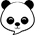

Generating train split: 20 examples [00:00, 540.32 examples/s]


In [373]:
#https://huggingface.co/datasets/mstz/balloons
from datasets import load_dataset
dataset = load_dataset("mstz/balloons", "adult_or_stretch")["train"]


In [378]:
dataset = pd.DataFrame(dataset)
dataset

,color,size,act,age,is_inflated
0,YELLOW,SMALL,STRETCH,ADULT,1
1,YELLOW,SMALL,STRETCH,ADULT,1
2,YELLOW,SMALL,STRETCH,CHILD,0
3,YELLOW,SMALL,DIP,ADULT,0
4,YELLOW,SMALL,DIP,CHILD,0
5,YELLOW,LARGE,STRETCH,ADULT,1
6,YELLOW,LARGE,STRETCH,ADULT,1
7,YELLOW,LARGE,STRETCH,CHILD,0
8,YELLOW,LARGE,DIP,ADULT,0
9,YELLOW,LARGE,DIP,CHILD,0


In [382]:
X_train, X_test, y_train, y_test = train_test_split(
        dataset.drop('is_inflated', axis=1),
        dataset['is_inflated'],
        test_size=0.3,
        random_state=42)

In [387]:
#Categorical and numerical columns
cat_columns = X_train.select_dtypes(
    include='object').columns.tolist()
num_columns = X_train.select_dtypes(
    exclude='object').columns.tolist()


In [394]:
#Pipeline
num_pipe = Pipeline([
    ('imp', SimpleImputer()),
    ('scaler', StandardScaler())
])


cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='constant')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

transformers = [('num', num_pipe, num_columns),
                ('cat', cat_pipe, cat_columns)]

transformer = ColumnTransformer(transformers=transformers)

ml_pipe = Pipeline([
    ('tf', transformer),
    ('logreg', LogisticRegression(solver='lbfgs',
    max_iter=200))
])

param_grid = {
    'tf__num__imp__strategy': ['mean', 'median', 'constant'],
    'tf__cat__imp__strategy': ['most_frequent', 'constant'],
    'logreg__C': [.01, .1, .5, 1, 5, 10, 100]
}

gs = GridSearchCV(ml_pipe,
                  param_grid,
                  cv=5)

gs.fit(X_train, y_train)

c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `spars

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         []),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['color',
                                                                          'size',
                                                                          'act',
                                                                          'age'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=200))]),
             param_grid={'logreg__C': [0.01, 0.1, 0.5, 1, 5, 10, 100],
                         'tf__cat__imp__strategy': ['most_frequent',
                                                    'constant'],
                         'tf__num__imp__strategy': ['mean', 'median',
                                                    'constant']})

In [395]:
print("Best_params:\n{}".format(
gs.best_params_))

print("best_score_: {:.3f}".format(
gs.best_score_))

print("best_score_test:{:.3f}".format(
gs.score(X_test, y_test)))

Best_params:
{'logreg__C': 5, 'tf__cat__imp__strategy': 'most_frequent', 'tf__num__imp__strategy': 'mean'}
best_score_: 0.933
best_score_test:1.000


In [396]:
cat = gs.best_estimator_['tf'].named_transformers_['cat']
onehot_columns = list(cat.named_steps['ohe'].get_feature_names_out(
    input_features=cat_columns))

In [397]:
all_cols = num_columns + onehot_columns
all_cols

['color_PURPLE',
 'color_YELLOW',
 'size_LARGE',
 'size_SMALL',
 'act_DIP',
 'act_STRETCH',
 'age_ADULT',
 'age_CHILD']

In [398]:
intercept = np.round(gs.best_estimator_['logreg'].intercept_[0], 3)
intercept

-2.054

In [399]:
coef = np.round(gs.best_estimator_['logreg'].coef_, 3)
coef

array([[ 0.297, -0.297,  0.21 , -0.209, -1.795,  1.795,  1.705, -1.705]])

In [400]:

print("intercept:", intercept)

print("Coef:")

for c, feature in zip(coef[0], all_cols):
    print(feature, c)

intercept: -2.054
Coef:
color_PURPLE 0.297
color_YELLOW -0.297
size_LARGE 0.21
size_SMALL -0.209
act_DIP -1.795
act_STRETCH 1.795
age_ADULT 1.705
age_CHILD -1.705


In [401]:
results = pd.DataFrame(gs.cv_results_)

table = results.pivot_table(
    values=['mean_test_score'],
    index=['param_logreg__C',
        'param_tf__cat__imp__strategy',
        'param_tf__num__imp__strategy'])
print(table)

                                                                           mean_test_score
param_logreg__C param_tf__cat__imp__strategy param_tf__num__imp__strategy                 
0.01            constant                     constant                             0.733333
                                             mean                                 0.733333
                                             median                               0.733333
                most_frequent                constant                             0.733333
                                             mean                                 0.733333
                                             median                               0.733333
0.10            constant                     constant                             0.733333
                                             mean                                 0.733333
                                             median                               0.733333

In [404]:
#progress bar
from tqdm import tqdm
scores = []
scoring = 'accuracy'
print("Looking for best hyperparameters...")

#Use tqdm and ParameterGrid

for param in tqdm(list(ParameterGrid(param_grid)),
                        desc='Выполнено'):

    ml_pipe.set_params(**param)

    scores.append([param, cross_val_score(ml_pipe,
                                            X_train,
                                            y_train,
                                            scoring=scoring,
                                            cv=5)])

    scores[-1].append(sum(scores[-1][1]) / len(scores[-1][1]))

scores.sort(reverse=True, key=lambda x: x[2])

best_params = scores[0][0]
print("Best hyperparameters:",
       best_params, sep='\n', end='\n')

best_score = scores[0][2]
print("Best meaning is %s: %.3f" % (scoring, best_score))

ml_pipe.set_params(**best_params).fit(X_train, y_train)

test_score = ml_pipe.score(X_test, y_test)

print("Meaning %s on test: %.3f" % (scoring, test_score))

Looking for best hyperparameters...


Выполнено:   0%|          | 0/42 [00:00<?, ?it/s]c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\prep

Best hyperparameters:
{'logreg__C': 5, 'tf__cat__imp__strategy': 'most_frequent', 'tf__num__imp__strategy': 'mean'}
Best meaning is accuracy: 0.933
Meaning accuracy on test: 1.000



c:\Users\Андрей Куликов\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
